# Experiment 7

## Oranges vs Grapefruit
https://www.kaggle.com/joshmcadams/oranges-vs-grapefruit

Grapefruit en Sinaasappels onderscheiden puur op uiterlijk is niet de makkelijkste taak, helemaal niet voor computers.
Deze dataset is bedoeld als proef om te zien hoe praktisch dit is.

In [26]:
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from misc_utilities import plot_roc_curve
df = pd.read_csv("citrus.csv")

## Analyse probleem
#### Wat is het probleem?
Binaire classificatie
#### Dimensies dataset?
10000 rijen, 5 features

In [27]:
print(f'Rows/Columns: {df.shape}')
print(f"Class distribution is: \n{df['name'].value_counts()}\n")
print(df.isnull().sum())

Rows/Columns: (10000, 6)
Class distribution is: 
orange        5000
grapefruit    5000
Name: name, dtype: int64

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64


We hebben 10000 rijen, en de labels staan in balans tot elkaar.

#### Soorten data/features?

We hebben een categorische target feature, en voor de rest numerieke features die het fruit beschrijven.

a:\software\coding projects\aai\aaivenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


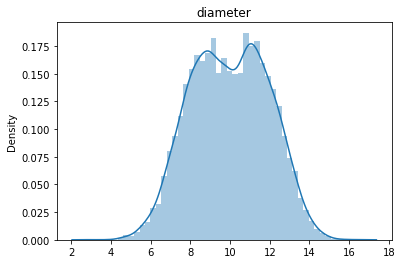

a:\software\coding projects\aai\aaivenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


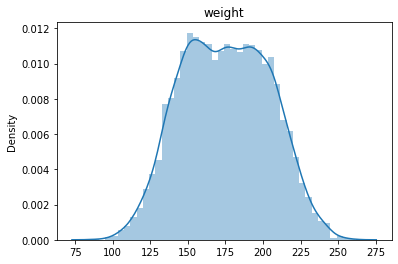

a:\software\coding projects\aai\aaivenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


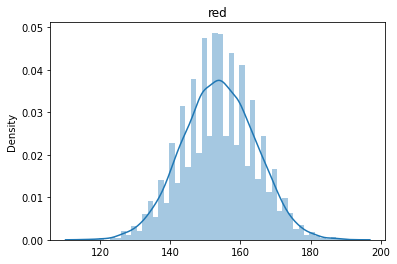

a:\software\coding projects\aai\aaivenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


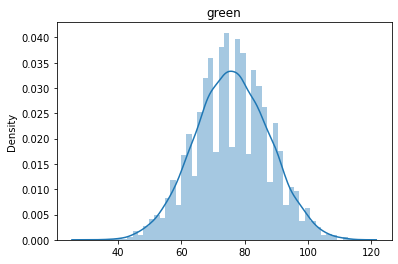

a:\software\coding projects\aai\aaivenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


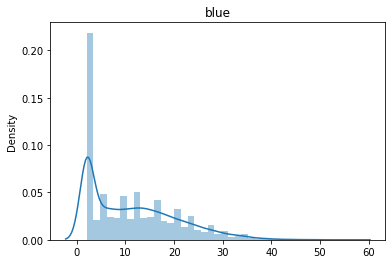

In [28]:
for column in df.columns[1:]:
    sns.distplot(x=df[column])
    plt.title(column)
    plt.show()

Hierboven kan je de distributie grafieken zien voor de features. Bij rood en groen is er niet veel op aan te merken,
deze hebben een normaalverdeling. Bij blauw zien we wat aparts in het feit dat het gewicht allemaal in één richting
geconcetreerd is. Ook bij gewicht en diameter zien we niet een perfecte normaal verdeling. In deze twee gevallen, lijkt
het also de piek van de lijn is afgesneden, wat zou kunnen suggereren dat in deze features er onderscheid gemaakt kan
worden tussen de soorten fruit.

Text(0.5, 1.0, 'Boxplot')

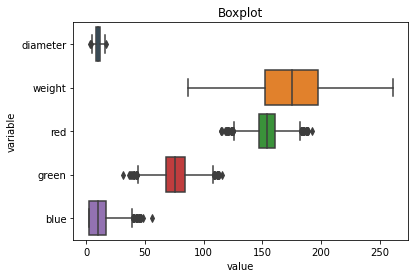

In [29]:

temp_dict = {col: df[col] for col in df.columns[1:]}
temp_df = pd.DataFrame(temp_dict, columns=temp_dict.keys())
temp_df = temp_df.melt()
sns.boxplot(x='value', y='variable', data=temp_df).set_title("Boxplot")

Hierboven boxplots voor de features. Bij de kleuren zien we niet heel veel schokkends, behalve misschien dat er wel
veel outliers zijn, wat handig is om in gedachte te houden. Bij diameter kunnen we zien dat de waardes grotendeels vrij
dict op elkaar zitten, dus misschien is dit niet heel handig om te gebruiken als input. Bij gewicht zien we een enorm
grote range aan waardes, dus misschien is deze feature wel bepalend voor de classificatie.

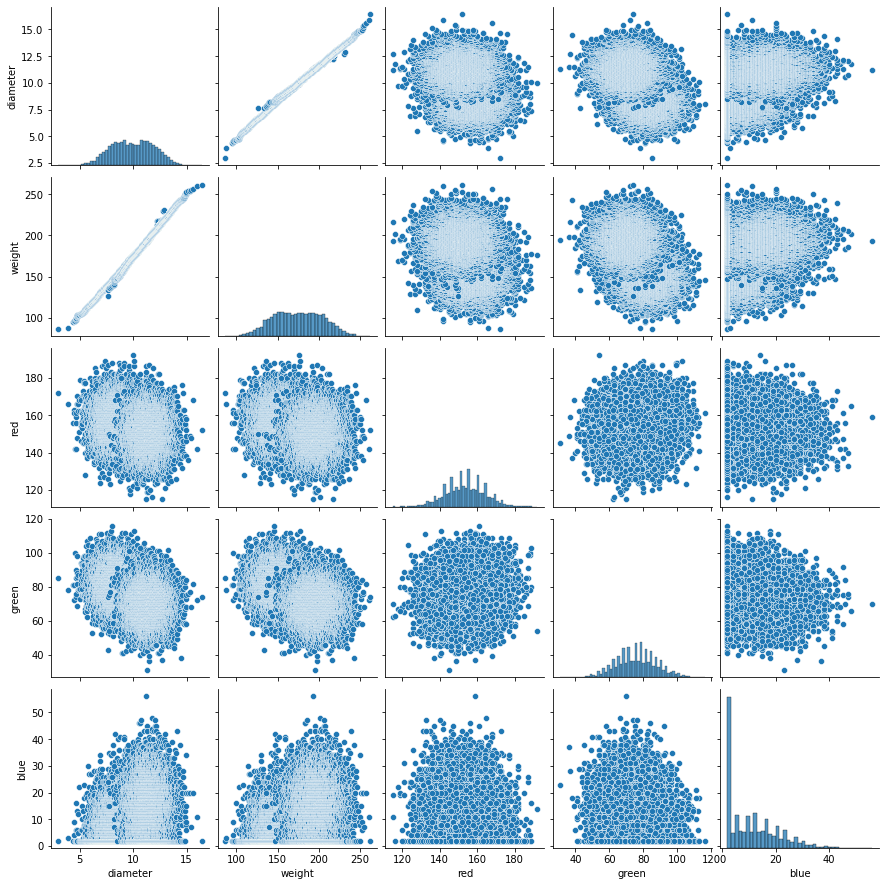

In [30]:
temp_df = df[df.columns[1:]]
sns.pairplot(temp_df)

Bij de scatterplot komen de echt interessante resultaten naar boven! Ten eerste kunnen we zien dat er geen significante
gaten in de data zitten, dus hier hoeven we niet aan te denken. Ten tweede kunnen we zien dat er geen correlatie is
tussen de kleuren zelf, en een er lineare correlatie is tussen diameter en gewicht. Maar bij de plots tussen
gewicht/diameter en de verschillende kleurwaardes zien we een overduidelijke trend, je ziet duidelijk twee groepen! Dit
 betekent dat ons probleem goed op te lossen zal zijn.

In [31]:
orange, grapefruit = [d for _, d in df.groupby(['name'])]

t, p = ttest_ind(orange['diameter'], grapefruit['diameter'], equal_var=False)
print(f"T value: {t} | P value: {p}")

t, p = ttest_ind(orange['weight'], grapefruit['weight'], equal_var=False)
print(f"T value: {t} | P value: {p}")


f, p = f_oneway(orange['diameter'], grapefruit['diameter'])
print(f"F value: {f} | P value: {p}")

T value: 120.96567386074341 | P value: 0.0
T value: 117.49837000434881 | P value: 0.0
F value: 14632.694252583738 | P value: 0.0


Als laatste independent T-test's op diameter en gewicht om echt te bevestigen dat de twee groepen anders zijn.

Alle P waardes staan op 0, wat betekent niks van onze data toevallig is gebeurt.

Beide T waardes zitten rond de 120, wat betekent dat de groepen zeker verschillend zijn.

De F waarde is rond de 14600, wat betekent dat er genoeg variatie zit tussen de means van de 2 groepen.

## Methoden
#### Welke preprocessing is nodig?
Label encoding, meer niet.
#### Welke modellen ga je vergelijken?
Modellen die zeker niet (relatief gezien) goed zullen werken, zijn Naive Bayes en Support Vector Machine. Bij NB
wordt er aangenomen dat de features independent zijn, maar we hebben aangetoond dat dat niet het geval is bij ons. SVM
gebruik je vaak in problemen met heel veel features, omdat SVM goed is met hoge dimensionaliteit, maar we hebben maar
een handvol features, dus SVM kan hier niet optimaal gebruikt worden.

Er zullen meer zijn, maar de 2 modellen die ik verwacht die het goed zullen doen zijn K Nearest Neighbour en
Random Forest. KNN omdat je duidelijk verschillende clusters in de scatterplots kon zien. RF omdat er duidelijke
scheidingen zijn in de data tussen de fruit soorten, en decision trees daar goed gebruikt van kunnen maken.
#### Welke performance metric is passend?
We gaan als basis accuracy gebruiken sinds de labels in balans zijn, en we geen groter gewicht hechten aan één van de
twee stukken fruit. Als extra informatie gaan we ook naar de ROC curve kijken om te zien hoe de modellen het doen op
verschillende momenten.

## Voorspelling
#### Welke classifier zal het beste zijn en waarom?

Ik verwacht dat Random Forest het doen, desondanks mijn argument voor KNN in de modelkeuze paragraaf. Dit is met reden
dat ik denk dat de split punten in de decision trees heel sterk bepaald kunnen worden met deze dataset.

#### Welke hyperparameters zijn relevant en waarom?
Ik ga alleen max_depth voor RF en n_neighbours voor KNN tweaken.

## Process

In [32]:
enc = LabelEncoder()
labels = enc.fit_transform(df['name'])
df.pop('name')

X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size=0.8, stratify=labels, shuffle=True)

In [33]:
rf = RandomForestClassifier(max_depth=15)
knn = KNeighborsClassifier(51)

In [34]:
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=51)

In [35]:
rf_pred = rf.predict(X_test)
knn_pred = knn.predict(X_test)

## Resultaten


Accuracy Random Forest: 0.9615
Accuracy K Nearest Neigbour: 0.925


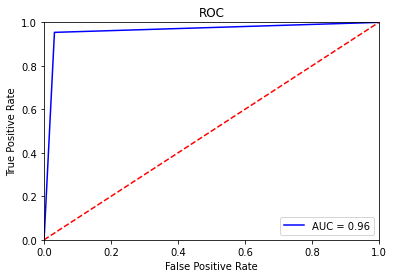

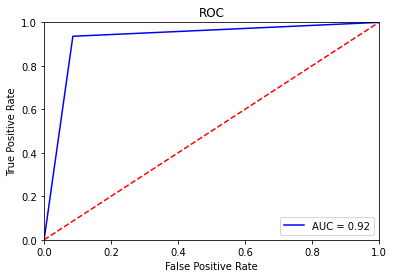

In [36]:
rf_acc = accuracy_score(y_test, rf_pred)
knn_acc = accuracy_score(y_test, knn_pred)

print(f"Accuracy Random Forest: {rf_acc}")
print(f"Accuracy K Nearest Neigbour: {knn_acc}")

plot_roc_curve(y_test, rf_pred)
plot_roc_curve(y_test, knn_pred)

## Conclusie
#### Welke classifier had het beste resultaat?
Random Forest met een accuracy van 0.9575
#### Kwam dit overeen met de voorspelling? Waarom wel/niet?
Dit kwam overeen met mijn voorspelling. Als je naar de ROC curve van KNN kijkt zie je dat de eerste verticale lijn
schuiner naar rechts loopt bij de eerste classificatie treshold, terwijl RF dichter bij de linkerboven hoek zit met een
veel gelijkere helling, wat nog een indicatie is dat RF dit probleem beter kan oplossen.